In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4329.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4223.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4253.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4190.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4354.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4136.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4226.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4214.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4888.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4170.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4323.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4262.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4788.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4657.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4387.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4255.jpg
/kaggle/

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
import warnings
warnings.filterwarnings("ignore")

In [4]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define the same transformation for test data without data augmentation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 4

train_dataset = datasets.ImageFolder('/kaggle/input/cat-and-dog/training_set/training_set', transform = train_transform)
test_dataset = datasets.ImageFolder('/kaggle/input/cat-and-dog/test_set/test_set', transform = test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

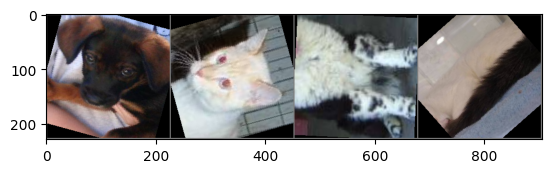

Dog   Cat   Dog   Cat  


In [5]:
classes = ['Cat', 'Dog']

def imshow(image):
    image = image / 2 + 0.5
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
images, labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

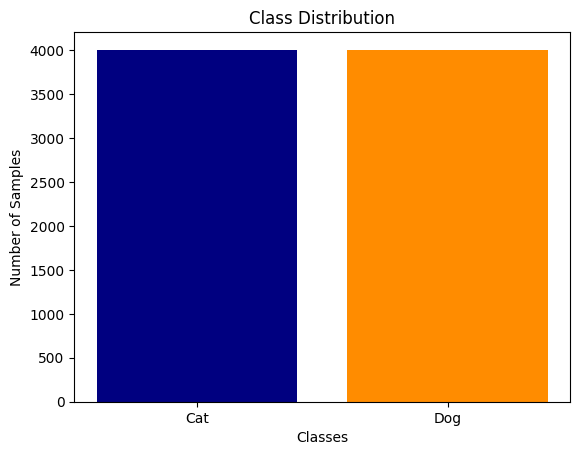

In [8]:
import matplotlib.pyplot as plt

def plot_class_distribution(dataset, classes):
    class_counts = {class_name: 0 for class_name in classes}
    
    for _, label in dataset:
        class_counts[classes[label]] += 1

    sorted_classes = sorted(classes)

    colors = ['navy','darkorange']
    
    plt.bar(sorted_classes, [class_counts[class_name] for class_name in sorted_classes], color=colors)
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution')
    plt.show()

plot_class_distribution(train_dataset, classes)


In [11]:
import numpy as np
from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def convert_to_numpy(loader):
    images, labels = [], []
    for data in loader:
        img, lbl = data
        images.append(img.numpy())
        labels.append(lbl.numpy())
    return np.vstack(images), np.hstack(labels)

X_train, y_train = convert_to_numpy(train_loader)
X_test, y_test = convert_to_numpy(test_loader)

target_size = (64, 64)
X_train_resized = np.array([transform.resize(img.transpose(1, 2, 0), target_size).flatten() for img in X_train])
X_test_resized = np.array([transform.resize(img.transpose(1, 2, 0), target_size).flatten() for img in X_test])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resized)
X_test_scaled = scaler.transform(X_test_resized)

def preprocess_images(images, target_size):
    processed_images = []
    for image in images:
        resized_image = transform.resize(image, target_size, mode='constant')
        flattened_image = resized_image.flatten()
        processed_images.append(flattened_image)
    return np.array(processed_images)

######

target_size = (64, 64)
######

X_train = preprocess_images(X_train_scaled, target_size)

X_test = preprocess_images(X_test_scaled, target_size)

input_size = X_train.shape[1]
hidden_size = 128
output_size = 1

np.random.seed(42)
weights_hidden = np.random.randn(input_size, hidden_size)
biases_hidden = np.zeros((1, hidden_size))
weights_output = np.random.randn(hidden_size, output_size)
biases_output = np.zeros((1, output_size))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

learning_rate = 0.01
epochs = 1000

for epoch in range(epochs):
    hidden_layer_input = np.dot(X_train, weights_hidden) + biases_hidden
    hidden_layer_output = sigmoid(hidden_layer_input)
    
    output_layer_input = np.dot(hidden_layer_output, weights_output) + biases_output
    predicted_output = sigmoid(output_layer_input)
    
    error = y_train.reshape(-1, 1) - predicted_output
    loss = 0.5 * np.mean(error ** 2)

    output_error = error * sigmoid_derivative(predicted_output)
    hidden_layer_error = output_error.dot(weights_output.T) * sigmoid_derivative(hidden_layer_output)
    
    weights_output += learning_rate * hidden_layer_output.T.dot(output_error)
    biases_output += learning_rate * np.sum(output_error, axis=0, keepdims=True)
    weights_hidden += learning_rate * X_train.T.dot(hidden_layer_error)
    biases_hidden += learning_rate * np.sum(hidden_layer_error, axis=0, keepdims=True)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

hidden_layer_input_test = np.dot(X_test, weights_hidden) + biases_hidden
hidden_layer_output_test = sigmoid(hidden_layer_input_test)
output_layer_input_test = np.dot(hidden_layer_output_test, weights_output) + biases_output
predicted_output_test = sigmoid(output_layer_input_test)

binary_predictions = (predicted_output_test > 0.5).astype(int)

accuracy = np.mean(binary_predictions == y_test.reshape(-1, 1))
print(f"Accuracy on test set: {accuracy * 100}%")

Epoch 0, Loss: 0.22260337451623688
Epoch 100, Loss: 0.24984380835876913
Epoch 200, Loss: 0.2498438068156373
Epoch 300, Loss: 0.24984380516055404
Epoch 400, Loss: 0.24984380338221557
Epoch 500, Loss: 0.249843801467729
Epoch 600, Loss: 0.24984379940230175
Epoch 700, Loss: 0.24984379716885435
Epoch 800, Loss: 0.24984379474753327
Epoch 900, Loss: 0.24984379211509364
Accuracy on test set: 50.024715768660414%


Top1 Accuracy: 50.024715768660414%
Top5 Accuracy: 0%
Confusion Matrix:
[[   0 1011]
 [   0 1012]]
AUC-ROC Score: 0.5437406903508052
Precision: 0.5002471576866041
Recall: 1.0
F1 Score: 0.6668863261943987
True Positive (TP): 1012
False Positive (FP): 1011
True Negative (TN): 0
False Negative (FN): 0
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1011
           1       0.50      1.00      0.67      1012

    accuracy                           0.50      2023
   macro avg       0.25      0.50      0.33      2023
weighted avg       0.25      0.50      0.33      2023



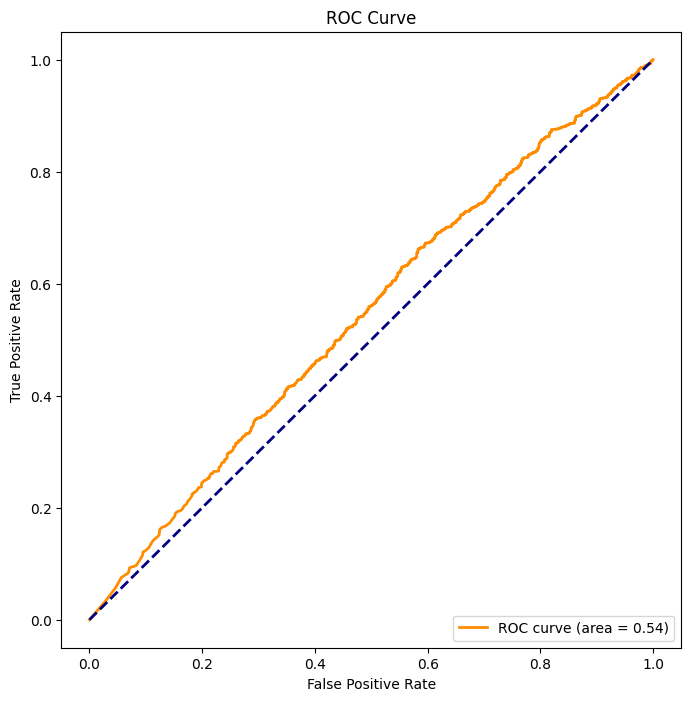

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, classification_report

def generate_metrics(y_true, y_pred_proba, y_pred_labels):
    threshold = 0.5
    y_pred_labels_thresholded = (y_pred_proba > threshold).astype(int)

    top1_accuracy = accuracy_score(y_true, y_pred_labels)
    top5_accuracy = 0 
    
    conf_matrix = confusion_matrix(y_true, y_pred_labels)

    roc_auc = roc_auc_score(y_true, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)

    precision = precision_score(y_true, y_pred_labels_thresholded)
    recall = recall_score(y_true, y_pred_labels_thresholded)
    f1 = f1_score(y_true, y_pred_labels_thresholded)

    class_report = classification_report(y_true, y_pred_labels_thresholded)

    tp = conf_matrix[1, 1]
    fp = conf_matrix[0, 1]
    tn = conf_matrix[0, 0]
    fn = conf_matrix[1, 0]

    print(f"Top1 Accuracy: {top1_accuracy * 100}%")
    print(f"Top5 Accuracy: {top5_accuracy * 100}%")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"AUC-ROC Score: {roc_auc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"True Positive (TP): {tp}")
    print(f"False Positive (FP): {fp}")
    print(f"True Negative (TN): {tn}")
    print(f"False Negative (FN): {fn}")
    print("Classification Report:\n", class_report)

generate_metrics(y_test, predicted_output_test, binary_predictions)

fpr, tpr, thresholds = roc_curve(y_test, predicted_output_test)
roc_auc = roc_auc_score(y_test, predicted_output_test)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
